This is my attempt to recreate the Bootstrap Demo from Dr. Pyrcz

In [2]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

In [3]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math as m                          # trig etc.
import scipy.signal as signal             # kernel for moving window calculation
import random

First step is to set the working directory using os 

In [4]:
os.chdir("/Users/AlexDodd/Desktop/Python Practice/Bootstrap")   #sets working path to my file 

Next is to load our data, using a random porosity grid of data

In [5]:
df = pd.read_excel('Random_Porosity.xlsx')

Next we will take out samples for Bootstrap to increase variation

In [6]:
df = df.sample(frac = 0.9)                  # extract 50 random samples to reduce the size of the dataset   
print('Using ' + str(len(df)) + ' number of samples')

Using 260 number of samples


Next to quickly look at our loaded data

In [7]:
df.head(n = 13) #shows first 13 rows

,X,Y,Porosity
2,100,600,0.08
220,290,239,0.22
84,900,679,0.24
278,140,279,0.12
16,400,700,0.20
222,20,499,0.10
206,400,99,0.07
34,900,900,0.22
268,830,49,0.21
165,180,209,0.19


Quickly looking at the summary statistics for our data

In [8]:
df.describe().transpose() #easier to view in my opinion transposed

,count,mean,std,min,25%,50%,75%,max
X,260.0,471.846154,254.492559,0.00,300.0,425.00,670.0,990.00
Y,260.0,533.484615,299.074808,9.00,279.0,549.00,831.5,999.00
Porosity,260.0,0.148346,0.058804,0.05,0.1,0.15,0.2,0.25


Next we will set the map grid to visualize the different porosity values for already changed data

In [9]:
xmin = 0.0
xmax = 1000.0
ymin = 0.0
ymax = 1000.0
porosity_min = 0.04
porosity_max = 0.26
color_map = plt.cm.plasma # plasma color map

Next showing what goes into the GSLIB plot parameters, uses locmap from matplotlib

In [10]:
GSLIB.locmap_st

<function geostatspy.GSLIB.locmap_st(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap)>

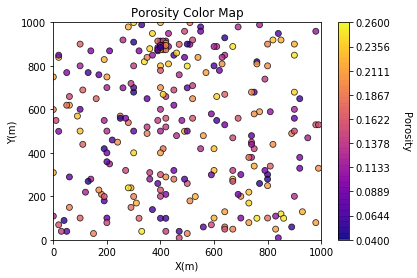

In [11]:
GSLIB.locmap_st(df,'X','Y','Porosity', xmin, xmax,ymin, ymax, porosity_min,porosity_max, 'Porosity Color Map', 'X(m)','Y(m)', 'Porosity', color_map)
plt.show()

Next step is to decluster our values, calculating declustering weights to apply to our data. Below shows the inputs for our declustering function:

In [12]:
geostats.declus

<function geostatspy.geostats.declus(df, xcol, ycol, vcol, iminmax, noff, ncell, cmin, cmax)>

In [13]:
weights, cell_sizes, means = geostats.declus(df,'X','Y','Porosity', iminmax = 1 , noff= 10, ncell = 100, cmin = 10, cmax = 2000 )
df['Weights'] = weights                    # add weights to the sample data DataFrame
df.head()                                  # preview to check the sample data DataFrame

def weighted_avg_std(values,weights):      #calculates mean and std
    average = np.average(values,weights=weights)  #average of an array of data then weights
    variance = np.average((values-average)**2,weights=weights)  #calculates variance from difference squared from the data and average
    return (average, m.sqrt(variance))
sample_avg,sample_stddev = weighted_avg_std(df['Porosity'],df['Weights'])
print('Declustered mean = ' + str(round(sample_avg,3)) + ' and declustered standard deviation = ' + str(round(sample_stddev,3)))

There are 260 data with:
   mean of      0.14834615384615388 
   min and max  0.05 and 0.25
   standard dev 0.058690480362722376 
Declustered mean = 0.148 and declustered standard deviation = 0.059


Bootstrap Realizations: Next we will make a few loops through our porosity data set to randomly select data, replace it and calculate the summary statistics to find the uncertainty in the summary statistics (mean,stddev etc). The random choices inputs are shown:

Signature: random.choices(population, weights=None, *, cum_weights=None, k=1)
Docstring:
Return a k sized list of population elements chosen with replacement.

If the relative weights or cumulative weights are not specified,
the selections are made with equal probability.
File:      ~/opt/anaconda3/lib/python3.7/random.py
Type:      method

In [14]:
df.head()

,X,Y,Porosity,Weights
2,100,600,0.08,1.003059
220,290,239,0.22,0.910230
84,900,679,0.24,0.932987
278,140,279,0.12,1.107982
16,400,700,0.20,0.740493


In [96]:
sample1= random.choices(df['Porosity'].values,df['Weights'].values,cum_weights=None, k = len(df))
sample2= random.choices(df['Porosity'].values,df['Weights'].values,cum_weights=None, k = len(df))
print ('Bootstrap Means: for realization 1 is ', str(np.average(sample1)), ' and realization 2 is ' , str(np.average(sample2)))


Bootstrap Means: for realization 1 is  0.14392307692307693  and realization 2 is  0.14984615384615385


Bootstrap means, realization 1 = 0.14611538461538462 and realization 2 = 0.14723076923076925


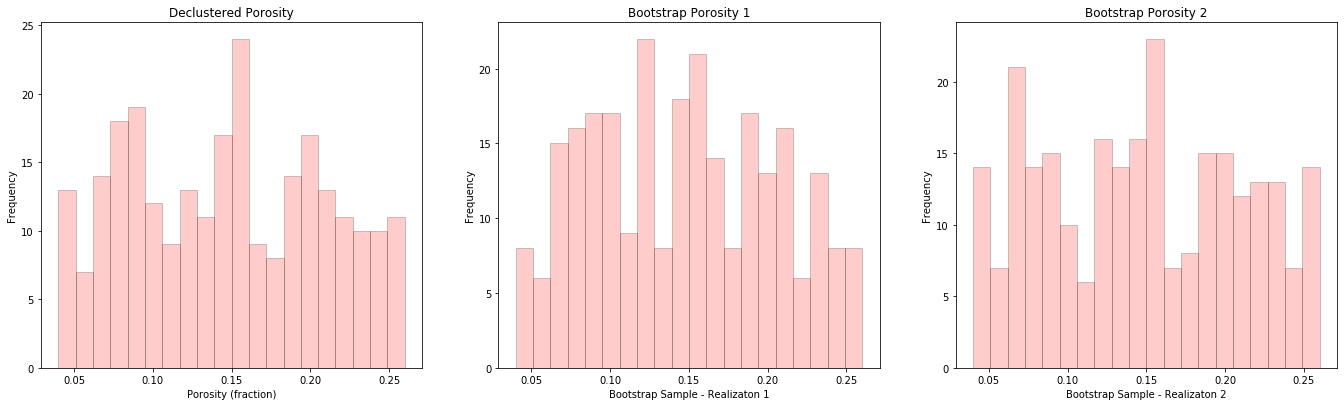

In [97]:
samples1 = random.choices(df['Porosity'].values, weights=df['Weights'].values, cum_weights=None, k=len(df))
samples2 = random.choices(df['Porosity'].values, weights=df['Weights'].values, cum_weights=None, k=len(df))

print('Bootstrap means, realization 1 = ' + str(np.average(samples1)) + ' and realization 2 = ' + str(np.average(samples2)))

plt.subplot(131)
GSLIB.hist_st(df['Porosity'],porosity_min,porosity_max,False,False,20,df['Weights'],'Porosity (fraction)','Declustered Porosity')

plt.subplot(132)
GSLIB.hist_st(samples1,porosity_min,porosity_max,False,False,20,None,'Bootstrap Sample - Realizaton 1','Bootstrap Porosity 1')

plt.subplot(133)
GSLIB.hist_st(samples2,porosity_min,porosity_max,False,False,20,None,'Bootstrap Sample - Realizaton 2','Bootstrap Porosity 2')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Next we will loop over to randomly sample and replace the data to caluclate the average and standard deviation in the data. The np.zeros function will create an array of zeros the length of realizations (samples with replacements) then we will randomly choose a data point, calculate the average and standard deviation, then replace the data over the lenght of the realizations

In [98]:
random.choices

<bound method Random.choices of <random.Random object at 0x7fd89903b220>>

In [99]:
L = 1000              #number of realizations that we will be using
average = np.zeros(L) #populate the average that with an array of zeros to be populated
stddev = np.zeros(L)  #populate the standard deviation with an array of zeros to be populated
for i in range (0,L):
    samples = random.choices(df['Porosity'].values,weights=df['Weights'].values,cum_weights=None,k=len(df))
    average[i]= np.average(samples)
    stddev[i]=np.std(samples)


Now plotting the uncertainty in the porosity average and uncertainty 

In [100]:
GSLIB.hist_st

<function geostatspy.GSLIB.hist_st(array, xmin, xmax, log, cumul, bins, weights, xlabel, title)>

Summary Statistics for the Bootstrap Average Porosity
DescribeResult(nobs=1000, minmax=(0.1338076923076923, 0.15711538461538463), mean=0.14653326923076923, variance=1.315013945158176e-05, skewness=-0.10125972864751333, kurtosis=-0.13472929930093036)
P90 = 0.142, P50 = 0.147, P10 = 0.151


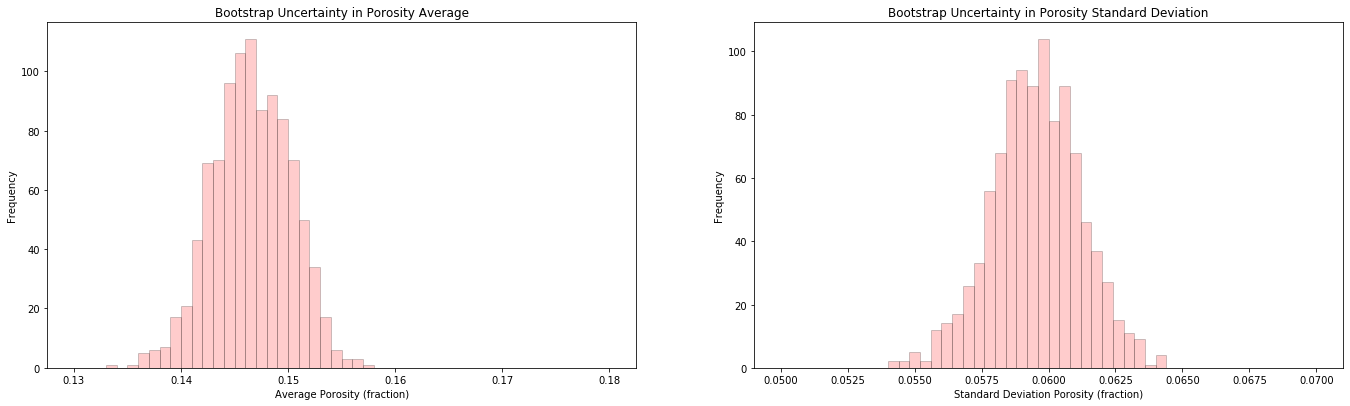

In [101]:
plt.subplot(121)
GSLIB.hist_st(average,.13,.18,False,False,50,None,'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average')

plt.subplot(122)
GSLIB.hist_st(stddev,.05,.07,False,False,50,None,'Standard Deviation Porosity (fraction)','Bootstrap Uncertainty in Porosity Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)

print('Summary Statistics for the Bootstrap Average Porosity')
print(stats.describe(average))
print('P90 = ' + str(round(np.percentile(average,10),3))+ ','+' P50 = ' + str(round(np.percentile(average,50),3))+ ','+' P10 = ' + str(round(np.percentile(average,90),3)))